In [1]:
import numpy as np
from model_aug_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/shiftx_aug_argminW_lr0.0002_new_aug/checkpoint"
sample_dir = "./out/shiftx_aug_argminW_lr0.0002_new_aug/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

loading mnist...
 [*] Reading checkpoints... ./out/shiftx_aug_argminW_lr0.0002_new_aug/checkpoint
INFO:tensorflow:Restoring parameters from ./out/shiftx_aug_argminW_lr0.0002_new_aug/checkpoint/model.b64-108800
 [*] Success to read model.b64-108800


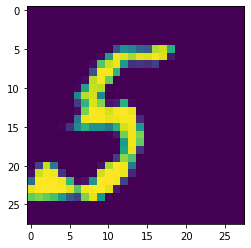

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/walk_train_aug/shiftx_l2_git{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 6)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
#             Loss_sum = Loss_sum + curr_loss
#             loss_values.append(curr_loss)

#             elapsed_time = time.time() - start_time

#             logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))
                
#             alpha_list.append(alpha_val)

#             if (optim_iter % 100 == 0) and (optim_iter > 0):
#                 saver.save(sess, './shift_l2_git/model_{}.ckpt'.format(optim_iter*batch_size), write_meta_graph=False, write_state=False)

#             optim_iter = optim_iter+1
            
#     if optim_iter > 0:
#         print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
#     saver.save(sess, "./shift_l2_git/model_{}_final.ckpt".format(optim_iter*batch_size), write_meta_graph=False, write_state=False)
#     return loss_values
            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-18 09:57:17,912 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.19758152961730957, 0, 0, 0.15813669562339783, 3
2019-09-18 09:57:17,921 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007588386535644531, 0, 10, 0.18901926279067993, -4
2019-09-18 09:57:17,929 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0072917938232421875, 0, 20, 0.11698758602142334, 1
2019-09-18 09:57:17,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007729768753051758, 0, 30, 0.1761581152677536, -3
2019-09-18 09:57:17,947 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0086669921875, 0, 40, 0.1600305140018463, 5
2019-09-18 09:57:17,958 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009232282638549805, 0, 50, 0.15106382966041565, -2
2019-09-18 09:57:17,967 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008775711059570312, 0, 60, 0.14836882054805756, -3
2019-09-18 09:57:17,977 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008117198944091797, 0, 70, 0.1822243630886078, -5
2019-09-18 09:57:17,986 [MainThread 

2019-09-18 09:57:18,568 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008865594863891602, 0, 680, 0.135506272315979, 3
2019-09-18 09:57:18,577 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008271932601928711, 0, 690, 0.1680389791727066, -5
2019-09-18 09:57:18,587 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008738517761230469, 0, 700, 0.09779396653175354, 1
2019-09-18 09:57:18,597 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008586406707763672, 0, 710, 0.07402878254652023, -1
2019-09-18 09:57:18,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008877277374267578, 0, 720, 0.10449276119470596, 2
2019-09-18 09:57:18,617 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008692264556884766, 0, 730, 0.1474064737558365, 4
2019-09-18 09:57:18,627 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008965015411376953, 0, 740, 0.09813433885574341, 1
2019-09-18 09:57:18,636 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008368492126464844, 0, 750, 0.13530947268009186, -4
2019-09-18 09:57:18,646 [

2019-09-18 09:57:19,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013788223266601562, 0, 1350, 0.07434535771608353, -1
2019-09-18 09:57:19,229 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008331775665283203, 0, 1360, 0.13879339396953583, 5
2019-09-18 09:57:19,239 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009024381637573242, 0, 1370, 0.1464286595582962, -5
2019-09-18 09:57:19,249 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008385181427001953, 0, 1380, 0.1342063695192337, 3
2019-09-18 09:57:19,259 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00929570198059082, 0, 1390, 0.14861826598644257, 4
2019-09-18 09:57:19,270 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009069442749023438, 0, 1400, 0.12242128700017929, 2
2019-09-18 09:57:19,279 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008330583572387695, 0, 1410, 0.12389767915010452, -2
2019-09-18 09:57:19,289 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008368968963623047, 0, 1420, 0.1343289166688919, 5
2019-09-18 09:57:

2019-09-18 09:57:19,905 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009077072143554688, 0, 2020, 0.11663476377725601, 2
2019-09-18 09:57:19,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009312629699707031, 0, 2030, 0.14497250318527222, -3
2019-09-18 09:57:19,926 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009354352951049805, 0, 2040, 0.13305582106113434, -5
2019-09-18 09:57:19,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009686708450317383, 0, 2050, 0.12143823504447937, -3
2019-09-18 09:57:19,947 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008901834487915039, 0, 2060, 0.12774072587490082, 5
2019-09-18 09:57:19,957 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008646249771118164, 0, 2070, 0.14866670966148376, -5
2019-09-18 09:57:19,967 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00911569595336914, 0, 2080, 0.1367129683494568, 5
2019-09-18 09:57:19,978 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008997917175292969, 0, 2090, 0.13149161636829376, 5
2019-09-18 09:

2019-09-18 09:57:20,599 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008785724639892578, 0, 2690, 0.06851039081811905, 1
2019-09-18 09:57:20,609 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00897359848022461, 0, 2700, 0.1060670018196106, -4
2019-09-18 09:57:20,620 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009211540222167969, 0, 2710, 0.06771442294120789, 1
2019-09-18 09:57:20,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009063959121704102, 0, 2720, 0.14280305802822113, -5
2019-09-18 09:57:20,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009057760238647461, 0, 2730, 0.1251816302537918, -3
2019-09-18 09:57:20,651 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008979320526123047, 0, 2740, 0.1298956274986267, -5
2019-09-18 09:57:20,662 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009455442428588867, 0, 2750, 0.0944429263472557, 3
2019-09-18 09:57:20,672 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008761405944824219, 0, 2760, 0.11768519878387451, 5
2019-09-18 09:57:

2019-09-18 09:57:21,293 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008637666702270508, 0, 3350, 0.07063817977905273, -1
2019-09-18 09:57:21,304 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008836030960083008, 0, 3360, 0.16032500565052032, -5
2019-09-18 09:57:21,315 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00900578498840332, 0, 3370, 0.11760979145765305, 2
2019-09-18 09:57:21,326 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009124279022216797, 0, 3380, 0.11133775115013123, 3
2019-09-18 09:57:21,336 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009506940841674805, 0, 3390, 0.14453795552253723, 5
2019-09-18 09:57:21,347 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009256601333618164, 0, 3400, 0.06523703038692474, 1
2019-09-18 09:57:21,358 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009588003158569336, 0, 3410, 0.10978251695632935, 3
2019-09-18 09:57:21,370 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01019287109375, 0, 3420, 0.13116386532783508, -3
2019-09-18 09:57:2

2019-09-18 09:57:21,980 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009648561477661133, 0, 4010, 0.10317731648683548, 3
2019-09-18 09:57:21,990 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008933544158935547, 0, 4020, 0.10209259390830994, -2
2019-09-18 09:57:22,000 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009207010269165039, 0, 4030, 0.14385591447353363, -4
2019-09-18 09:57:22,011 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009204387664794922, 0, 4040, 0.06946445256471634, 1
2019-09-18 09:57:22,021 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009202957153320312, 0, 4050, 0.13701847195625305, -5
2019-09-18 09:57:22,031 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009160757064819336, 0, 4060, 0.07098761945962906, -1
2019-09-18 09:57:22,042 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009351968765258789, 0, 4070, 0.16023756563663483, 5
2019-09-18 09:57:22,052 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009103536605834961, 0, 4080, 0.10742392390966415, 2
2019-09-18 0

2019-09-18 09:57:22,691 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008866310119628906, 0, 4680, 0.10298527032136917, 4
2019-09-18 09:57:22,702 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009293317794799805, 0, 4690, 0.1426093876361847, -4
2019-09-18 09:57:22,713 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009432315826416016, 0, 4700, 0.10497143864631653, -3
2019-09-18 09:57:22,723 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009046316146850586, 0, 4710, 0.13068336248397827, 5
2019-09-18 09:57:22,734 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009504079818725586, 0, 4720, 0.12215837836265564, -4
2019-09-18 09:57:22,744 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009186983108520508, 0, 4730, 0.05577390268445015, 1
2019-09-18 09:57:22,755 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009130716323852539, 0, 4740, 0.08139082044363022, 2
2019-09-18 09:57:22,766 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009576559066772461, 0, 4750, 0.11840558797121048, 3
2019-09-18 09:

2019-09-18 09:57:23,392 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009157180786132812, 0, 5340, 0.038151808083057404, -1
2019-09-18 09:57:23,402 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009258031845092773, 0, 5350, 0.09519573301076889, 2
2019-09-18 09:57:23,412 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00875997543334961, 0, 5360, 0.11794285476207733, 4
2019-09-18 09:57:23,422 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00894021987915039, 0, 5370, 0.12505985796451569, 5
2019-09-18 09:57:23,432 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008774995803833008, 0, 5380, 0.10502593219280243, 3
2019-09-18 09:57:23,442 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009219884872436523, 0, 5390, 0.04267766699194908, -1
2019-09-18 09:57:23,452 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00890040397644043, 0, 5400, 0.07383114099502563, 2
2019-09-18 09:57:23,462 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008667469024658203, 0, 5410, 0.08079607784748077, -2
2019-09-18 09:5

Loss: [0.013552816547453404, 0.011917719196528197, 0.011159521501511335, 0.011392970491200685, 0.010354029808193445, 0.009661073822528125]
2019-09-18 09:57:24,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00910043716430664, 0, 6010, 0.10821681469678879, -3
2019-09-18 09:57:24,090 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008746862411499023, 0, 6020, 0.12001188099384308, 4
2019-09-18 09:57:24,100 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008182764053344727, 0, 6030, 0.04712492600083351, -1
2019-09-18 09:57:24,110 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008734464645385742, 0, 6040, 0.10508539527654648, 3
2019-09-18 09:57:24,119 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008432865142822266, 0, 6050, 0.08437861502170563, -2
2019-09-18 09:57:24,129 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008519887924194336, 0, 6060, 0.107271708548069, 3
2019-09-18 09:57:24,138 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008547544479370117, 0, 6070, 0.082333505153656, 2
20

2019-09-18 09:57:24,704 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008167505264282227, 0, 6670, 0.06374450027942657, 2
2019-09-18 09:57:24,713 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008264541625976562, 0, 6680, 0.11447322368621826, 4
2019-09-18 09:57:24,722 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008227348327636719, 0, 6690, 0.11599133908748627, -4
2019-09-18 09:57:24,732 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008281230926513672, 0, 6700, 0.11847808212041855, 4
2019-09-18 09:57:24,741 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008450031280517578, 0, 6710, 0.09413375705480576, -3
2019-09-18 09:57:24,751 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008115291595458984, 0, 6720, 0.10103828459978104, -4
2019-09-18 09:57:24,760 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008239507675170898, 0, 6730, 0.1299276053905487, 5
2019-09-18 09:57:24,770 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008532285690307617, 0, 6740, 0.09589170664548874, -3
2019-09-18 09

2019-09-18 09:57:25,356 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008521556854248047, 0, 7330, 0.08032222092151642, 3
2019-09-18 09:57:25,366 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008906126022338867, 0, 7340, 0.031130855903029442, -1
2019-09-18 09:57:25,377 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010340452194213867, 0, 7350, 0.11797966808080673, 5
2019-09-18 09:57:25,388 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009236574172973633, 0, 7360, 0.062366705387830734, -2
2019-09-18 09:57:25,402 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012877225875854492, 0, 7370, 0.10088928043842316, -4
2019-09-18 09:57:25,412 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008537054061889648, 0, 7380, 0.14345864951610565, -5
2019-09-18 09:57:25,421 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008635282516479492, 0, 7390, 0.029188573360443115, -1
2019-09-18 09:57:25,431 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00878286361694336, 0, 7400, 0.10731741786003113, -4
2019-09-

2019-09-18 09:57:26,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00902247428894043, 0, 8000, 0.028402136638760567, 1
Loss: [0.013552816547453404, 0.011917719196528197, 0.011159521501511335, 0.011392970491200685, 0.010354029808193445, 0.009661073822528125, 0.008670647023245692, 0.008062064593657851]
2019-09-18 09:57:26,024 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008909940719604492, 0, 8010, 0.06148622930049896, -2
2019-09-18 09:57:26,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00884699821472168, 0, 8020, 0.13388927280902863, -5
2019-09-18 09:57:26,045 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008157014846801758, 0, 8030, 0.10882517695426941, -4
2019-09-18 09:57:26,054 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008165359497070312, 0, 8040, 0.11832704395055771, 4
2019-09-18 09:57:26,064 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00824284553527832, 0, 8050, 0.10136620700359344, 4
2019-09-18 09:57:26,073 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0080120

2019-09-18 09:57:26,701 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009509086608886719, 0, 8660, 0.12281869351863861, 5
2019-09-18 09:57:26,716 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014326095581054688, 0, 8670, 0.0296611450612545, 1
2019-09-18 09:57:26,726 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00878453254699707, 0, 8680, 0.11409076303243637, 5
2019-09-18 09:57:26,736 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008991241455078125, 0, 8690, 0.06548023968935013, -2
2019-09-18 09:57:26,746 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00902867317199707, 0, 8700, 0.08842862397432327, -3
2019-09-18 09:57:26,757 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009182929992675781, 0, 8710, 0.028249597176909447, 1
2019-09-18 09:57:26,767 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009159088134765625, 0, 8720, 0.02397957630455494, 1
2019-09-18 09:57:26,778 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009400129318237305, 0, 8730, 0.0709691196680069, 3
2019-09-18 09:57:

2019-09-18 09:57:27,394 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008876800537109375, 0, 9310, 0.02517511323094368, -1
2019-09-18 09:57:27,404 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008879423141479492, 0, 9320, 0.08551102876663208, -3
2019-09-18 09:57:27,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008798360824584961, 0, 9330, 0.05283617973327637, -2
2019-09-18 09:57:27,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009576797485351562, 0, 9340, 0.10836183279752731, -5
2019-09-18 09:57:27,435 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008932828903198242, 0, 9350, 0.08525245636701584, 4
2019-09-18 09:57:27,445 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009377717971801758, 0, 9360, 0.05044431611895561, -2
2019-09-18 09:57:27,456 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00925302505493164, 0, 9370, 0.025996007025241852, 1
2019-09-18 09:57:27,477 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020762205123901367, 0, 9380, 0.07518792152404785, 3
2019-09-18 

2019-09-18 09:57:28,114 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014151573181152344, 0, 9980, 0.08989395946264267, 5
2019-09-18 09:57:28,124 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008682012557983398, 0, 9990, 0.06969325244426727, 3
2019-09-18 09:57:28,134 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009523153305053711, 0, 10000, 0.06083500012755394, 3
Loss: [0.013552816547453404, 0.011917719196528197, 0.011159521501511335, 0.011392970491200685, 0.010354029808193445, 0.009661073822528125, 0.008670647023245692, 0.008062064593657851, 0.0072829290311783555, 0.006660131812095642]
2019-09-18 09:57:28,145 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009307622909545898, 0, 10010, 0.05680675432085991, -2
2019-09-18 09:57:28,155 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009069204330444336, 0, 10020, 0.054964736104011536, -2
2019-09-18 09:57:28,165 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00871133804321289, 0, 10030, 0.04208642244338989, -2
2019-09-18 09:57:28,176 [Ma

2019-09-18 09:57:28,788 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00898432731628418, 0, 10630, 0.04454386606812477, 2
2019-09-18 09:57:28,799 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008989572525024414, 0, 10640, 0.08272460103034973, 4
2019-09-18 09:57:28,809 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009325027465820312, 0, 10650, 0.05455990508198738, 2
2019-09-18 09:57:28,819 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008939027786254883, 0, 10660, 0.1078212633728981, 5
2019-09-18 09:57:28,829 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008960247039794922, 0, 10670, 0.02189110964536667, 1
2019-09-18 09:57:28,839 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009174108505249023, 0, 10680, 0.10599667578935623, 5
2019-09-18 09:57:28,849 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008780479431152344, 0, 10690, 0.09741119295358658, 5
2019-09-18 09:57:28,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009077787399291992, 0, 10700, 0.0869695395231247, -4
2019-09-18

2019-09-18 09:57:29,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008872032165527344, 0, 11270, 0.07821875065565109, 4
2019-09-18 09:57:29,457 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009215593338012695, 0, 11280, 0.09769203513860703, 4
2019-09-18 09:57:29,467 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009122133255004883, 0, 11290, 0.02028757333755493, -1
2019-09-18 09:57:29,478 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009224891662597656, 0, 11300, 0.018680749461054802, 1
2019-09-18 09:57:29,488 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008981466293334961, 0, 11310, 0.08451525121927261, -3
2019-09-18 09:57:29,498 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008897066116333008, 0, 11320, 0.052276115864515305, -2
2019-09-18 09:57:29,508 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008629322052001953, 0, 11330, 0.09176040440797806, -5
2019-09-18 09:57:29,519 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01055455207824707, 0, 11340, 0.023926282301545143, 1
20

2019-09-18 09:57:30,130 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009254217147827148, 0, 11930, 0.05389515310525894, 2
2019-09-18 09:57:30,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009215831756591797, 0, 11940, 0.02156374603509903, 1
2019-09-18 09:57:30,151 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009087562561035156, 0, 11950, 0.11424519121646881, -5
2019-09-18 09:57:30,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008949518203735352, 0, 11960, 0.018454253673553467, -1
2019-09-18 09:57:30,171 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009495019912719727, 0, 11970, 0.10588511824607849, -5
2019-09-18 09:57:30,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009018898010253906, 0, 11980, 0.07076774537563324, 3
2019-09-18 09:57:30,192 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00913095474243164, 0, 11990, 0.02342255227267742, -1
2019-09-18 09:57:30,202 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009491205215454102, 0, 12000, 0.08330333977937698, -4
Los

2019-09-18 09:57:30,795 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009417295455932617, 0, 12570, 0.02095620706677437, 1
2019-09-18 09:57:30,805 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009189844131469727, 0, 12580, 0.04439729079604149, -2
2019-09-18 09:57:30,816 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009545564651489258, 0, 12590, 0.10084547847509384, 5
2019-09-18 09:57:30,827 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009878396987915039, 0, 12600, 0.07892712205648422, -4
2019-09-18 09:57:30,837 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009307861328125, 0, 12610, 0.05026146024465561, 2
2019-09-18 09:57:30,848 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009072065353393555, 0, 12620, 0.017642585560679436, -1
2019-09-18 09:57:30,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009870290756225586, 0, 12630, 0.01926390454173088, 1
2019-09-18 09:57:30,869 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008862733840942383, 0, 12640, 0.03800790384411812, -2
2019-0

2019-09-18 09:57:31,483 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008547067642211914, 0, 13210, 0.04684855788946152, -2
2019-09-18 09:57:31,492 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008245229721069336, 0, 13220, 0.03705985099077225, 2
2019-09-18 09:57:31,502 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00887441635131836, 0, 13230, 0.09366726875305176, 5
2019-09-18 09:57:31,516 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012437820434570312, 0, 13240, 0.06635254621505737, -3
2019-09-18 09:57:31,526 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008687019348144531, 0, 13250, 0.07205423712730408, -3
2019-09-18 09:57:31,535 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008784770965576172, 0, 13260, 0.09698779881000519, -5
2019-09-18 09:57:31,545 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008557319641113281, 0, 13270, 0.058178335428237915, -3
2019-09-18 09:57:31,555 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009006738662719727, 0, 13280, 0.016855930909514427, -1
2

2019-09-18 09:57:32,155 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008859872817993164, 0, 13870, 0.07600723952054977, 5
2019-09-18 09:57:32,165 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008683919906616211, 0, 13880, 0.05896928161382675, 3
2019-09-18 09:57:32,175 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008505105972290039, 0, 13890, 0.04257868230342865, -2
2019-09-18 09:57:32,184 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008329391479492188, 0, 13900, 0.08031722158193588, -5
2019-09-18 09:57:32,194 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00891733169555664, 0, 13910, 0.03733719140291214, -2
2019-09-18 09:57:32,204 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008374929428100586, 0, 13920, 0.05452290549874306, 2
2019-09-18 09:57:32,213 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00847172737121582, 0, 13930, 0.10088630020618439, -4
2019-09-18 09:57:32,223 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008419036865234375, 0, 13940, 0.049375981092453, -2
2019-09

2019-09-18 09:57:32,796 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01043844223022461, 0, 14510, 0.08173628151416779, 3
2019-09-18 09:57:32,806 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008726835250854492, 0, 14520, 0.09206610918045044, 5
2019-09-18 09:57:32,816 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008413314819335938, 0, 14530, 0.09660256654024124, -5
2019-09-18 09:57:32,825 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00840902328491211, 0, 14540, 0.03972488269209862, 2
2019-09-18 09:57:32,836 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009552240371704102, 0, 14550, 0.02398063614964485, -1
2019-09-18 09:57:32,847 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009568214416503906, 0, 14560, 0.01881718449294567, -1
2019-09-18 09:57:32,857 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008885383605957031, 0, 14570, 0.09619711339473724, 5
2019-09-18 09:57:32,867 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008824348449707031, 0, 14580, 0.017123136669397354, 1
2019-0

2019-09-18 09:57:33,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008596420288085938, 0, 15150, 0.0469915047287941, -2
2019-09-18 09:57:33,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008848428726196289, 0, 15160, 0.09812729060649872, 5
2019-09-18 09:57:33,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009285926818847656, 0, 15170, 0.04539688304066658, 2
2019-09-18 09:57:33,450 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008532047271728516, 0, 15180, 0.08234520256519318, -4
2019-09-18 09:57:33,460 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009031295776367188, 0, 15190, 0.09080424904823303, -5
2019-09-18 09:57:33,470 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008949518203735352, 0, 15200, 0.09685324877500534, 5
2019-09-18 09:57:33,480 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008987903594970703, 0, 15210, 0.0711827352643013, -4
2019-09-18 09:57:33,490 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008832693099975586, 0, 15220, 0.021318627521395683, 1
2019-

2019-09-18 09:57:34,099 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00908660888671875, 0, 15810, 0.08464953303337097, -5
2019-09-18 09:57:34,109 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009126663208007812, 0, 15820, 0.0882854089140892, 5
2019-09-18 09:57:34,120 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00921177864074707, 0, 15830, 0.06277090311050415, -3
2019-09-18 09:57:34,130 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008929729461669922, 0, 15840, 0.09181219339370728, 5
2019-09-18 09:57:34,139 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008820772171020508, 0, 15850, 0.021692773327231407, 1
2019-09-18 09:57:34,150 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009064912796020508, 0, 15860, 0.0982847586274147, -4
2019-09-18 09:57:34,160 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009415149688720703, 0, 15870, 0.02512477897107601, -1
2019-09-18 09:57:34,170 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009041309356689453, 0, 15880, 0.025934189558029175, 1
2019-0

2019-09-18 09:57:34,779 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009149551391601562, 0, 16440, 0.03114018775522709, 1
2019-09-18 09:57:34,789 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009124040603637695, 0, 16450, 0.09679193049669266, 5
2019-09-18 09:57:34,799 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009054899215698242, 0, 16460, 0.02098630554974079, -1
2019-09-18 09:57:34,809 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009099245071411133, 0, 16470, 0.06826889514923096, 3
2019-09-18 09:57:34,820 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009142160415649414, 0, 16480, 0.02277379296720028, 1
2019-09-18 09:57:34,830 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009010553359985352, 0, 16490, 0.1034531220793724, 4
2019-09-18 09:57:34,840 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008983135223388672, 0, 16500, 0.039981137961149216, -2
2019-09-18 09:57:34,850 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009322166442871094, 0, 16510, 0.02255379408597946, -1
2019-

2019-09-18 09:57:35,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011571407318115234, 0, 17070, 0.020235575735569, -1
2019-09-18 09:57:35,439 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008949518203735352, 0, 17080, 0.10907524824142456, -5
2019-09-18 09:57:35,449 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00874185562133789, 0, 17090, 0.056283820420503616, -2
2019-09-18 09:57:35,459 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008940458297729492, 0, 17100, 0.06519857794046402, -4
2019-09-18 09:57:35,470 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009289264678955078, 0, 17110, 0.05297825485467911, 3
2019-09-18 09:57:35,481 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009842395782470703, 0, 17120, 0.020413663238286972, 1
2019-09-18 09:57:35,491 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008929967880249023, 0, 17130, 0.0528716966509819, -2
2019-09-18 09:57:35,501 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009339570999145508, 0, 17140, 0.08187117427587509, 5
2019-

2019-09-18 09:57:36,101 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009231805801391602, 0, 17730, 0.025693217292428017, 1
2019-09-18 09:57:36,111 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008983373641967773, 0, 17740, 0.10530290752649307, 4
2019-09-18 09:57:36,121 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008941650390625, 0, 17750, 0.07109493762254715, -3
2019-09-18 09:57:36,131 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008887052536010742, 0, 17760, 0.08892789483070374, -4
2019-09-18 09:57:36,141 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008859395980834961, 0, 17770, 0.08466546982526779, 3
2019-09-18 09:57:36,151 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00965118408203125, 0, 17780, 0.08605024218559265, 4
2019-09-18 09:57:36,162 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009220361709594727, 0, 17790, 0.11400432884693146, -5
2019-09-18 09:57:36,172 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009118080139160156, 0, 17800, 0.024701900780200958, -1
2019-0

2019-09-18 09:57:36,755 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009002685546875, 0, 18360, 0.08644397556781769, -5
2019-09-18 09:57:36,765 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00887608528137207, 0, 18370, 0.11719951778650284, 5
2019-09-18 09:57:36,775 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009238719940185547, 0, 18380, 0.01769811287522316, 1
2019-09-18 09:57:36,786 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009371757507324219, 0, 18390, 0.01800363138318062, -1
2019-09-18 09:57:36,796 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009416818618774414, 0, 18400, 0.09835999459028244, 5
2019-09-18 09:57:36,812 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013974189758300781, 0, 18410, 0.04439718648791313, -2
2019-09-18 09:57:36,824 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010807991027832031, 0, 18420, 0.017258157953619957, 1
2019-09-18 09:57:36,834 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009324073791503906, 0, 18430, 0.022834761068224907, -1
2019-0

2019-09-18 09:57:37,455 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009422540664672852, 0, 19010, 0.020941702648997307, -1
2019-09-18 09:57:37,465 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009408712387084961, 0, 19020, 0.07064257562160492, 3
2019-09-18 09:57:37,476 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008913993835449219, 0, 19030, 0.09740131348371506, -5
2019-09-18 09:57:37,489 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012585639953613281, 0, 19040, 0.01702413335442543, 1
2019-09-18 09:57:37,499 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009006977081298828, 0, 19050, 0.021359393373131752, 1
2019-09-18 09:57:37,510 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009428977966308594, 0, 19060, 0.05714240297675133, -3
2019-09-18 09:57:37,521 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009663581848144531, 0, 19070, 0.04884133115410805, -2
2019-09-18 09:57:37,531 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009183645248413086, 0, 19080, 0.09723486006259918, -5
2

2019-09-18 09:57:38,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009261608123779297, 0, 19670, 0.05342951416969299, -2
2019-09-18 09:57:38,171 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008978843688964844, 0, 19680, 0.10261466354131699, 4
2019-09-18 09:57:38,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009067535400390625, 0, 19690, 0.0441853292286396, 2
2019-09-18 09:57:38,191 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00881338119506836, 0, 19700, 0.021136540919542313, -1
2019-09-18 09:57:38,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008810758590698242, 0, 19710, 0.09715539962053299, -5
2019-09-18 09:57:38,211 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00915074348449707, 0, 19720, 0.07439897954463959, 3
2019-09-18 09:57:38,227 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014204978942871094, 0, 19730, 0.03149104118347168, -2
2019-09-18 09:57:38,237 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00941610336303711, 0, 19740, 0.08080751448869705, -3
2019-0

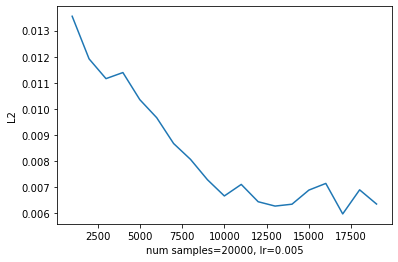

[0.013552816547453404, 0.011917719196528197, 0.011159521501511335, 0.011392970491200685, 0.010354029808193445, 0.009661073822528125, 0.008670647023245692, 0.008062064593657851, 0.0072829290311783555, 0.006660131812095642, 0.007102586880326271, 0.006438366413116455, 0.0062716229809448125, 0.00634368521720171, 0.006884916493669152, 0.007140696728602052, 0.005971046483144164, 0.006894778748974204, 0.006350361928343773]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/walk_train_aug/shiftx_l2_git0.005/output/model_20000.ckpt")

[-8 -6 -5 -4 -2  0  2  4  5  6  8]


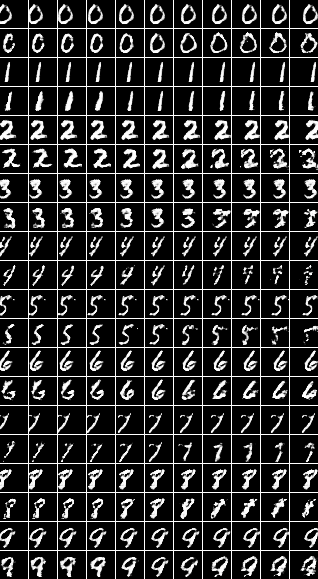

In [16]:
num_samples = 10
a = np.array([-8, -6, -5, -4, -2,  0,  2,  4,  5, 6,  8])

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -7.00, dist 0.03 +/- 0.02
alpha: -5.50, dist 0.01 +/- 0.01
alpha: -4.50, dist 0.02 +/- 0.01
alpha: -3.00, dist 0.05 +/- 0.03
alpha: -1.00, dist 0.06 +/- 0.03
alpha: 1.00, dist 0.06 +/- 0.03
alpha: 3.00, dist 0.05 +/- 0.03
alpha: 4.50, dist 0.02 +/- 0.01
alpha: 5.50, dist 0.01 +/- 0.01
alpha: 7.00, dist 0.03 +/- 0.02
2019-09-18 09:59:36,203 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-18 09:59:36,206 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


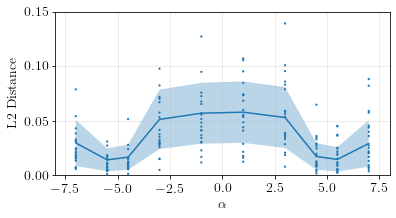

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'shiftx_aug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [27]:
dist_trained_joint = np.load("dist_trained_info-75epoch-joint.npy")

alpha: -8.00, dist 0.15 +/- 0.01
alpha: -6.00, dist 0.12 +/- 0.01
alpha: -5.00, dist 0.11 +/- 0.01
alpha: -4.00, dist 0.09 +/- 0.01
alpha: -2.00, dist 0.05 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 2.00, dist 0.05 +/- 0.01
alpha: 4.00, dist 0.09 +/- 0.01
alpha: 5.00, dist 0.10 +/- 0.01
alpha: 6.00, dist 0.12 +/- 0.01
alpha: 8.00, dist 0.14 +/- 0.01


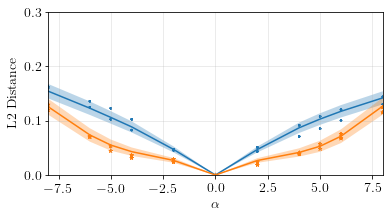

In [28]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'shiftx_aug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)

### For shift no joint
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples

### For shift join
mu_j = np.mean(dist_trained_joint, axis=0)
sd_j = np.std(dist_trained_joint, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_joint[:20]

ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())

ax.scatter(xscatter_j, yscatter_j, marker='*', edgecolors='none', s=20, color=p_j[0].get_color())

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)